# Procedure 3: Across-session-within-subject testing with [glhmm toolbox](https://github.com/vidaurre/glhmm)

In this tutorial, we show how to implement across-sessions testing using the [GLHMMS toolbox](https://github.com/vidaurre/glhmm), part of the paper [The Gaussian-Linear Hidden Markov Model: a Python Package](https://arxiv.org/abs/2312.07151). This method is particularly suited for studying variability across multiple sessions and is ideal for longitudinal studies.

For this example, we use data collected from a **single participant** performing a memory task during **Magnetoencephalography (MEG)** scanning. The participant completed the task over **15 sessions** spanning ~6 months. In each session:
- The participant viewed images and performed an *n*-back memory task.
- The participant was asked to recall the **animacy** of previously shown stimuli (animate vs. inanimate).

<div class="alert alert-block alert-info">
<b>Note:</b> This tutorial focuses on data from the occipital region of the brain (72 channels) and looks at patterns of activity in the alpha band (8-13 Hz). However, this analyses has also been run on delta-theta (1-8 Hz), beta (13-30 Hz) and gamma band (30-40 Hz) activity. The goal is to determine whether the brain processes animate and inanimate stimuli differently on a trial-by-trial basis.
To analyse a different frequency band, update the <code>freqs</code> and <code>band_name</code> parameters in the code.
</div>

---

### Objective of this Procedure
The key question we aim to answer is:  
**“Does the subject’s brain encode the same task consistently over time, or does the encoding change between sessions?”**

To address this, we will:
* Decode brain states: Train a Hidden Markov Model (HMM) to decode brain states from the MEG data for all sessions.
* Test relationships: **Use permutation testing** to examine the association between brain states ($D$ matrix) and the behavioural condition (animate vs. inanimate stimuli, represented by the $R$ matrix) and assess if these relationships remain consistent across sessions.

**Important**: For reliable results, you’ll need at least 7 sessions. This gives enough permutations (7! = 5040) to perform 1000 tests.

---

### Relationship to other Procedures

Steps 1–5 in this procedure are identical to those in **Procedure 2**, since both procedures use the same dataset and preprocessing steps.  
However, the **research focus** differs.
- **Procedure 2** examines variability **across trials**.
- **Procedure 3 (this tutorial)** tests the variability **across sessions** to see how consistent brain activity is over time.

---

### Structure of the Protocol
The steps in this tutorial follow the workflow shown in the figure below:

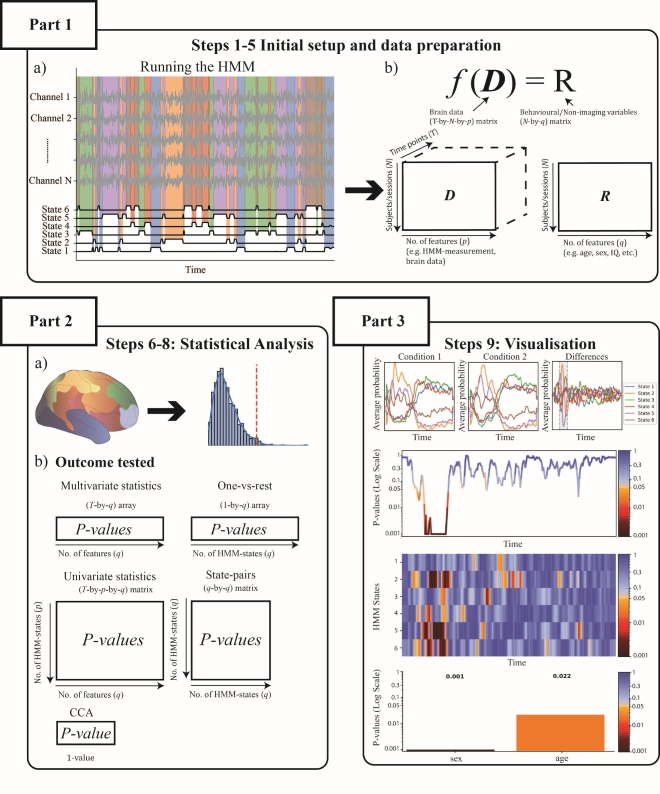

### Table of Contents
* [Part 1. Load and prepare data](#load-data)
    * [Step 1. Load data into Python environment](#prep_env)
    * [Step 2. Data structuring for the HMM](#data_shape)
    * [Step 3. Preprocessing data](#preprocess_data)
    * [Step 4. Set-up and train HMM](#data_handle1)
    * [Step 5. Configure HMM outputs for statistical analysis](#data_handle)
* [Part 2 & 3. Statistical Analysis and Visualisation](#stat_analysis)
    * [Step 6. Types of test - Across session test](#stat_test)
    * [Step 7. Multivariate test](#multi_test)
        * [Step 8. Multiple comparison test - Multivariate](#multi_corr)
        * [Step 9. P-value plots - Multivariate](#multi_vis)
    * [Step 7. Univariate test](#uni_test)
        * [Step 8. Multiple comparison test - Univariate](#uni_corr)
        * [Step 9. P-value plots - Univariate](#uni_corr2)
    * [Extra - FWER Correction](#uni_test3)

  

### Install necessary packages
If you don't have the **GLHMM-package** installed, then run the following command in your terminal:

```pip install git+https://github.com/vidaurre/glhmm```

### Import libraries
Let's start by importing the required libraries and modules.

In [1]:
# Import libraries
import numpy as np
from glhmm import glhmm, graphics, statistics, preproc
from pathlib import Path
import pickle

## Part 1. Initial setup and data preparation <a id="load-data"></a>
### Step 1. Load data into Python environment <a id="prep_env"></a>

The data we are using is stored in the folder `data_MEG`. It includes brain activity recordings (`D_raw`), behavioural labels (`R_data`), and event information (`event_data`). Each dataset plays an important role in analysing how the brain responds during different trials.


In [2]:
# Set up paths
PATH_WORKING = Path.cwd()

with open(Path("../ZENODO_PATH.txt")) as file:
    PATH_ZENODO = Path(file.read())

PATH_DATA = PATH_ZENODO / "Procedure_2_and_3_data"
PATH_HMM_DATA = PATH_DATA / "data_HMM"

# Load brain activity data
with open(PATH_DATA / "D_raw.pkl", "rb") as f:
    D_raw = pickle.load(f)

# Load behavioural data
with open(PATH_DATA / "R_data.pkl", "rb") as f:
    R_data = pickle.load(f)

# Load event data
with open(PATH_DATA / "event_markers.pkl", "rb") as f:
    event_markers = pickle.load(f)

# Display data information
print(f"Number of sessions in D_raw: {len(D_raw)}")
print(f"Number of trials in R_data: {len(R_data)}")
print(f"Number of event records in event_markers: {len(event_markers)}")

Number of sessions in D_raw: 15
Number of trials in R_data: 15
Number of event records in event_markers: 15


#### Explore the Dataset
The data comprises of brain activity (`D_raw`), behavioural measurements (`R_data`), and event information (`event_markers`). Each dataset serves a specific purpose and is structured to align with the trial data for analysis.

**Brain Data (`D_raw`)**\
The brain data is a list of 15 recordings, where each recording captures continuous brain activity from an entire session. Each session is stored as a 2D matrix `(No. of timepoints, No. of channels)`:
- Timepoints: Represent all recorded time points in the session.  
- Channels: Are 72 selected occipital channels from the MEG data.


**Behavioural Measurements (`R_data`)**  
The behavioural data is a list of 15, where each element represents a session. Each element is a 1D array, where:
- Length of the array: Matches the number of trials within the session.  
- Labels: Each trial is labelled as animate (`1`) or inanimate (`0`), based on the visual stimuli presented.

**Event Data (`event_markers`)**  
The event data is also a list of 15, aligning directly with `R_data` and corresponding to the same 15 sessions. Each element is a 2D array, where each row represents a trial and contains:
- Start time: The specific time in the brain recording (`D_raw`) when the trial begins.  
- Condition: Consistently `0` because the same trial type is used throughout the dataset. 
- Event code: A number identifying the type of event.


### Step 2. Data structuring for the HMM <a id="data_shape"></a>
To train the HMM, the brain activity data needs to be structured as a 2D matrix. This involves concatenating all MEG sessions (`D_raw`) along the time dimension to create a single, continuous dataset. The resulting matrix, referred to as `D_con`, has the shape ```[Total No. of timepoints across all trials, No. of channels]```. 

In addition to `D_con`, we need an index matrix to track the start and end timepoints for each session in the concatenated data. This matrix, referred to as `idx_data`, has the shape of ```[No. of subjects, 2]```.
Each row of the matrix specifies the start and end timepoints for a session. This step is important because the HMM must know where each session begins and ends to process the data correctly.

To create the index matrix, we use the `get_indices_from_list` function from the statistics module. This function extracts the boundaries directly from the original `D_raw` structure.


In [3]:
# Concatenate all MEG sessions into a single dataset
D_con = np.concatenate(D_raw, axis=0)

# Get the start and end indices for each session
idx_data = statistics.get_indices_from_list(D_raw)

# Display the shapes of the resulting structures
print(f"Shape of concatenated data (D_con): {D_con.shape}")
print(f"Shape of index matrix (idx_data): {idx_data.shape}")
print(f"Indices for each session:\n {idx_data}")

Shape of concatenated data (D_con): (10864515, 72)
Shape of index matrix (idx_data): (15, 2)
Indices for each session:
 [[       0  1530001]
 [ 1530001  3034002]
 [ 3034002  3768503]
 [ 3768503  4518504]
 [ 4518504  4881505]
 [ 4881505  5644506]
 [ 5644506  6398507]
 [ 6398507  6766508]
 [ 6766508  7504509]
 [ 7504509  7872510]
 [ 7872510  8626511]
 [ 8626511  9385512]
 [ 9385512  9750513]
 [ 9750513 10496514]
 [10496514 10864515]]


**Reviewing the data structure**

After structuring the data, it is helpful to inspect the shapes of `D_con` and `idx_data`:

- `D_con`: The concatenated dataset has the shape `(10864515, 72)`, corresponding to the total number of timepoints across all sessions and the 72 MEG channels.
- `idx_data`: The index matrix aligns with the 15 sessions and indicates the start and end timepoints for each session in `D_con`. For example, the first row might show `[0, 1530001]`, representing the time range for the first session.

### Step 3. Preprocessing data <a id="preprocess_data"></a>

Before we can train the HMM, we need to prepare the MEG data so it is ready for analysis.
However, **preprocessing and training the HMM are optional**. If you prefer, you can skip these steps and use the pre-saved `Gamma` values provided for this tutorial (see **Step 4**).\
The `Gamma` values, obtained from the HMM, represent the probabilities of being in each brain state at every timepoint and are central to the subsequent analysis.

For those who want to train the HMM themselves, the preprocessing steps are as follows:

---
#### Preprocessing Steps:
* *Filtering the Data:* We apply a band-pass filter to isolate activity within a frequency band of interest, in this example, the *alpha band* (8-13 Hz). 
* *Hilbert transform:* We will apply the Hilbert transform to get information about the strength (amplitude) and timing (phase) of brain waves.
* *Principal Component Analysis (PCA):* To reduce complexity, we retain 90% of the data variance using PCA. This simplifies the data and makes it faster to process.

These preprocessing steps help remove noise and unnecessary information, and let us focus on the brain activity of interest. 

---

**Why Do This?**\
Training the HMM on different frequency bands separately makes it possible to identify distinct states associated with specific oscillatory patterns. For example:

* *Delta-Theta (1–8 Hz)*: Linked to memory encoding and early processing of stimuli.
* *Alpha (8–13 Hz)*: Associated with attention and sensory filtering.
* *Beta (13–30 Hz)*: Involved in working memory and decision making.
* *Gamma (30–40 Hz)*: Problem solving and concentration

For this tutorial, we focus on the **alpha band** as an example, but the same steps can be applied to other bands.

In [4]:
# Define frequency bands and settings
band_name = "alpha"
freqs = (8, 13)  # Frequency range for band
pca_variance = 0.9  # Retain 90% of variance in PCA
fs = 1000  # Original sampling rate of the data
onpower = True  # Use Hilbert transform for amplitude and phase
f_target = 250  # Downsample to 250 Hz
K = 12  # Number of HMM states

**Preprocessing the Data**:\
If you choose to preprocess the data for HMM training: the following code performs the necessary steps.

In [ ]:
# Preprocess the data
data_session_preproc, idx_data_preproc = preproc.preprocess_data(
    data=D_con,
    indices=idx_data,
    fs=fs,
    standardise=True,  # Standardise the data
    filter=freqs,  # Apply band-pass filter
    onpower=onpower,  # Apply Hilbert transform
    pca=pca_variance,  # PCA to reduce dimensionality
    downsample=f_target  # Downsample to target frequency
)

### Step 4. Set-up and train a HMM <a id="data_handle1"></a>

An HMM helps us find patterns in brain activity over time. It identifies "states" in the data, which are distinct periods when the brain behaves in specific ways and shows how these states change.

One of the key outputs of training the HMM is the state time courses called `Gamma`. It tells us the probability of being in each state at every timepoint. Since Gamma is central to understanding how brain activity changes, it will be the focus of our subsequent analysis.

---

**Option 1: Skip Training with pre-saved `Gamma` values**
If you prefer to skip preprocessing and training the HMM, you can load pre-saved `Gamma` values directly. This allows you to proceed straight to the analysis phase without running previous steps. 

To load pre-saved results for the **alpha band**, copy and paste the following code into the next cell:

```python

# Run this to load pre-saved HMM results instead!
band_name = "alpha"
Gamma = np.load(PATH_HMM_DATA / f"Gamma_group_{band_name}.npy")
idx_data = np.load(PATH_HMM_DATA / f"idx_data_{band_name}.npy")

```
---

**Option 2: Train the HMM**\
If you have preprocessed the data yourself, you can train the HMM to generate new `Gamma` values. 

**Set up the model**\
For this tutorial, we use a standard Gaussian HMM. Here are the settings we use:
* `model_beta='no'`: No interaction modeling between variable sets.
* `K=12`: Number of brain states to identify (you can adjust this number as needed).
* `covtype='full'`: Each state uses a full covariance matrix.

**Train the model for each frequency band**\
The preprocessed MEG data (`data_session_preproc`) filtered to include only alpha band activity is the input (`Y`), and session indices (`idx_data_preproc`) marks beginning and end indices of each preprocessed session. As this is a standard HMM without interactions between variable sets, we set ```X=None```.

In [5]:
# Run this to load pre-saved HMM results instead!
band_name = "alpha"
Gamma = np.load(PATH_HMM_DATA / f"Gamma_group_{band_name}.npy")
idx_data = np.load(PATH_HMM_DATA / f"idx_data_{band_name}.npy")

In [ ]:
# Set up the model
hmm_classic = glhmm.glhmm(model_beta='no', K=K, covtype='full')

# Train the HMM
Gamma, _, _  = hmm_classic.train(X=None, Y=data_session_preproc, indices=idx_data_preproc)

Once the HMM training is complete, it provides three outputs that summarize the brain's state dynamics and the model's performance:

- **`Gamma`**: This tells us which state the brain is likely to be in at every time point. 

- **`Xi`**: This shows how often the brain switches between states.

- **`FE`**: A measure of how well the model fits the data (smaller values mean a better fit).

While the model is training, you'll see updates showing how the fit (`FE`) improves with each step.

### Step 5. Configure HMM outputs for statistical analysis <a id="data_handle"></a>

Now that we have the `Gamma` values from the HMM, we can study how these brain states relate to specific events in the data. Let us start by taking a look at the shape of the data

In [6]:
print(f"Data dimension of 'data_con': {D_con.shape}")
print(f"Data dimension of 'Gamma': {Gamma.shape}")

Data dimension of 'data_con': (10864515, 72)
Data dimension of 'Gamma': (2716140, 12)


Here’s what the numbers mean:

* **Original data (`data_con`)**: (10864515, 72)
    - This represents the original brain data with 10864515 timepoints and 72 MEG channels.
* **Gamma for delta-theta band**: (2716140, 12)
    - After processing, the time points are reduced to 2716140 timepoints and 12 brain states.

The first dimension (time points) has been reduced from 10864515 to 2716140 because we downsampled the data from 1000 Hz to 250 Hz. This means that the data now has four times fewer time points (10864515 ÷ 2716140 = 4), which matches the downsampling ratio (1000 ÷ 250 = 4).

The second dimension has also changed, reducing the number of columns from 72 channels to 12 states. Each column in the Gamma matrix now represents one of the HMM states.

**Epoch the data**\
To analyse brain responses to specific events, such as when a stimulus is presented, we divide the data into smaller time segments, called epochs. For each trial, we use an event file that marks when a stimulus was shown. By focusing on a specific window of time (e.g., 1 second after the stimulus), we can study how `Gamma` change in response to these events. Since the data has already been downsampled from 1000 Hz to 250 Hz, we need to adjust the timestamps inside the `event_markers` so they match the downsampled `Gamma` data.

In [7]:
fs_target= 250 # Define the target sampling frequency
epoch_window_tp = 250 # Set the epoch window length in timepoints

# Iterate over each frequency band in the data dictionary
gamma_epoch, idx_data_epoch, R_data_epoch = statistics.get_event_epochs(
    Gamma,                              # HMM state time courses
    idx_data,                           # Session indices
    R_data,                             # Additional data
    event_markers,                      # Event markers
    fs=fs,                              # Original sampling frequency
    fs_target=fs_target,                # Downsampled frequency
    epoch_window_tp=epoch_window_tp     # Epoch window length 
)

# Check the dimensions of the extracted data
print(f"Shape of D_data: {gamma_epoch.shape}")
print(f"Shape of R_data: {R_data_epoch.shape}")
print(f"Indices for each session:\n {idx_data_epoch}")

Shape of D_data: (250, 8368, 12)
Shape of R_data: (8368,)
Indices for each session:
 [[   0 1162]
 [1162 2307]
 [2307 2875]
 [2875 3456]
 [3456 3741]
 [3741 4322]
 [4322 4905]
 [4905 5197]
 [5197 5767]
 [5767 6056]
 [6056 6635]
 [6635 7213]
 [7213 7502]
 [7502 8076]
 [8076 8368]]


Now, we will look at the output.

* `gamma_epoch`: This contains the epoched Gamma data for each trial, with dimensions [No. of time points, No. of trials, No. of states]. For example:

    - In this example, `gamma_epoch` has dimensions (250, 8368, 12), meaning 250 time points per trial, 8368 trials, and 12 states.
* R_data_epoch: This array contains information about the stimulus type for each trial. In our case:
    - `0` indicates an inanimate object.
    - `1` indicates an animate object.
* `idx_data_epoch`: This matrix marks the start and end trial indices for each session. Each row corresponds to one session, and the two numbers in each row represent: 
    - Start Index: The trial number where the session begins.
    - End Index: The trial number where the session ends (non-inclusive).



## Part 2 & 3 - Statistical Analysis and visualisation <a id="stat_analysis"></a>

### 6. Types of test - Across-sessions test <a id="stat_test"></a>
With the `gamma_epoch` matrix representing brain data ($D$) and the `R_data_epoch` containing behavioural measurements ($R$) to whether an object was animate or inanimate, we can now perform statistical tests to study their relationships using the function `test_across_sessions`.
This test is designed to analyse variability across different sessions. In our case, it can help us understand if the brain encode the task consistently over time, or does the response to the task change across sessions. 

**What is Permutation Testing**\
Permutation testing is a statistical technique that tests for significance by creating a "null distribution". Instead of assuming a specific data distribution, it randomly shuffles the data to simulate a scenario where no relationship exists between the variables tested. For `test_across_sessions`, each observation corresponds to a trial within the same session. By comparing the results before and after shuffling, we can determine whether observed differences are statistically significant.


For instance:
- If shuffling the data results in a significant difference from the original arrangement, it suggests a strong relationship between brain states (`gamma_epoch`) and behavioural measurements (`R_data_epoch`).

This process is visualised in **Figure 5C** from the [paper](https://www.biorxiv.org/content/10.1101/2023.01.03.522583v4):

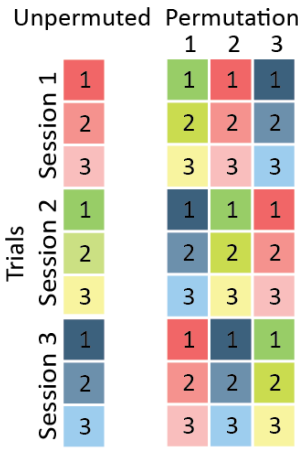


**A 9 x 4 matrix representing permutation testing across sessions**. Each number corresponds to a trial within a session and permutations are performed between sessions. The first column: displays the original index of each trial (perm=0). Next columns: examples of permuted sessions.

### Step 7. Multivariate Test <a id="multi_test"></a>

The multivariate analysis aims to evaluate whether the state time courses of our brain data ($D$, represented by ```Gamma_epoch```) contribute to explaining the observed variability in behavioural measurements ($R$, represented by ```R_data_epoch```) when viewing inanimate versus animate objects. This approach examines all state time courses simultaneously, testing whether patterns in state time courses contribute to the observed variability in the behavioural responses.


- **Significant results** suggest that the brain states (`Gamma_epoch`) collectively contribute to differences in how the task is processed across sessions.  
---

##### Inputs and Settings

To perform the multivariate analysis using the `test_across_subjects` function, the following inputs and settings are defined:

**Inputs:**
* ```D_data```: The state time courses of the brain data (```gamma_epoch```).
* ```R_data```: The behavioural measurements with the stimuli condition (```R_data_epoch```).
* ```idx_data``` : Indices for the first and last trial for a given session (```idx_data_epoch```)

**Settings:**
* ```method = "multivariate"```: Specifies that the test should perform multivariate analysis.
* ```Nperm```: Number of permutations (optional, default is 1000).
---

##### Run the ```test_across_sessions_within_subject``` function
We will store the results in a dictionary called `results_multivariate`, which will hold the outputs for the selected frequency band. This analysis will help identify whether state time courses change in a way that reflects the participant's response to **animate vs. inanimate stimuli** across sessions. 

Here’s the code to perform the test:

In [8]:
# Set parameters for multivariate testing
method = "multivariate"
Nperm = 10_000  # Number of permutations
test_statistics_option = True

# Perform across-trial testing
results_multivariate = statistics.test_across_sessions_within_subject(
    D_data=gamma_epoch,
    R_data=R_data_epoch,
    idx_data=idx_data_epoch,
    method=method,
    Nperm=Nperm,
)

Maximum number of permutations with 15 sessions is: 1.31e+12
performing permutation testing per timepoint


100%|██████████| 250/250 [19:34<00:00,  4.70s/it]


We can now examine the ```result_multivariate``` variable, which is a dictionary containing the results of a statistical analysis of each frequency band. Significant results indicate that FO patterns contribute to explaining differences in behavioural measurements, while non-significant results suggest there are none.

Let us break it down:
* ```pval```: This array holds the p-values resulting from the permutation test. Each value corresponds to a behavioural variable and will have shape of 1 by q, see [paper](https://www.biorxiv.org/content/10.1101/2023.01.03.522583v4).

* ```base_statistics```: Stores the base statistics of the tests. In this case it is the explained variance $R^2$

* ```test_statistic```: Will by default always return a list of the base (unpermuted) statistics when ```test_statistic_option=False```. This list can store the test statistics associated with the permutation test. It provides information about the permutation distribution that is used to calculate the p-values. The output will exported if we set ```test_statistic_option=True```

* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```test_across_sessions```

* ```method```: Specifies the analytical method employed, which is ```'multivariate'```, which means that the analysis is carried out using regression-based permutation testing

* ```test_combination``` Specifies whether p-values are combined. This can be done across rows (producing one p-value per row), across columns (producing one p-value per column), or into a single combined p-value for the entire matrix

* ```max_correction```: Boolean value that indicates whether Max correction has been applied when performing permutation testing

* ```statistical_measures```: A dictionary that marks the columns in the `test_statistics` or p-value matrix corresponding to the (q dimension) where t-tests or F-tests have been performed

* ```Nperm```: Is the number of permutations that has been performed

* ```test_summary```: A dictionary summarizing the test results based on the applied method.

In [11]:
# printing a summary 
statistics.display_test_summary(results_multivariate)


Model Summary (timepoint 0):
    Outcome     R²  F-stat  df1  df2  p-value (R²)
Regressor 1 0.0002   0.055   12 8356        0.1119

Coefficients Table (timepoint 0):
Predictor     Outcome    T-stat  p-value      LLCI      ULCI
  State 1 Regressor 1  0.010351 0.036304 -0.006801  0.010785
  State 2 Regressor 1  0.005465 0.249125 -0.007836  0.009187
  State 3 Regressor 1  0.015314 0.053105 -0.002842  0.017759
  State 4 Regressor 1 -0.005348 0.311231 -0.010288  0.002667
  State 5 Regressor 1 -0.005562 0.162516 -0.008847  0.001317
  State 6 Regressor 1 -0.003314 0.572357 -0.010629  0.004577
  State 7 Regressor 1  0.004140 0.248425 -0.006362  0.006959
  State 8 Regressor 1 -0.005936 0.212121 -0.010225  0.000158
  State 9 Regressor 1  0.001309 0.768977 -0.005587  0.009723
 State 10 Regressor 1 -0.012965 0.048205 -0.013832 -0.002320
 State 11 Regressor 1 -0.003809 0.248925 -0.005724  0.004926
 State 12 Regressor 1 -0.012297 0.025303 -0.012346  0.006577


#### Step 8. Multiple Comparison - Multivariate <a id="multi_corr"></a>
When running statistical tests, especially multivariate ones, it’s important to account for multiple comparisons. This helps reduce the risk of false positives (type I errors). To handle this, we apply two types of corrections to the p-values from the `results_multivariate` output:

* Benjamini/Hochberg Correction: This method adjusts p-values to control for false discovery rates. This uses the `pval_correction` function, which offers various correction methods based on the `statsmodels`' multitest module.

* Cluster-Based Correction: This method identifies clusters of significant results to reduce the risk of false positives. We focus on p-values below a threshold of 0.01 by setting `alpha=0.01`. This is implemented using the `pval_cluster_based_correction` function.

Here’s how we apply these corrections:

In [12]:
# Apply Benjamini/Hochberg correction to multivariate p-values
pval_fdr_bh, _ = statistics.pval_correction(
    results_multivariate, method='fdr_bh'
)

# Apply cluster-based correction to multivariate p-values
alpha = 0.01  # Significance threshold

pval_cluster = statistics.pval_cluster_based_correction(
    results_multivariate,
    alpha=alpha
)

#### Step 9. P-value plots - Multivariate  <a id="multi_vis"></a>
With both uncorrected and corrected p-values calculated, we can now visualise them using the `plot_p_values_over_time` function.\
This helps to better understand the results by showing how p-values change over time for each condition.
For the multivariate test, the p-values are stored as an array with the shape `[number of time points, q]`, where $q=1$ because we are comparing only one condition:
animate vs. inanimate objects.

In our case, the p-value array has the shape (250, 1), as the data spans 250 time points per trial.\
Since the stimulus presentation starts at 0 seconds and ends after 1000 ms, we will set the x-axis limits to:
* `x_tick_min = 0`
* `x_tick_max = 1000`

And we will be focusing on p-values below a threshold of 0.01
* `alpha = 0.01`




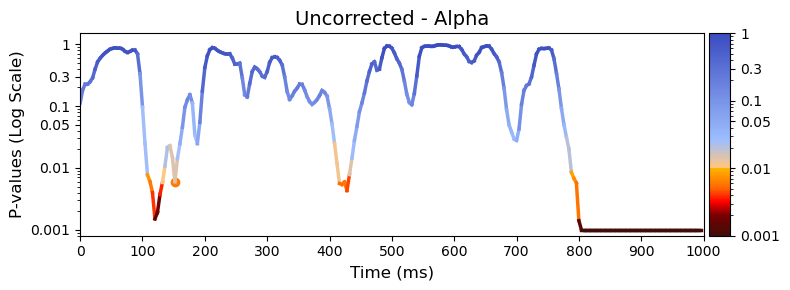

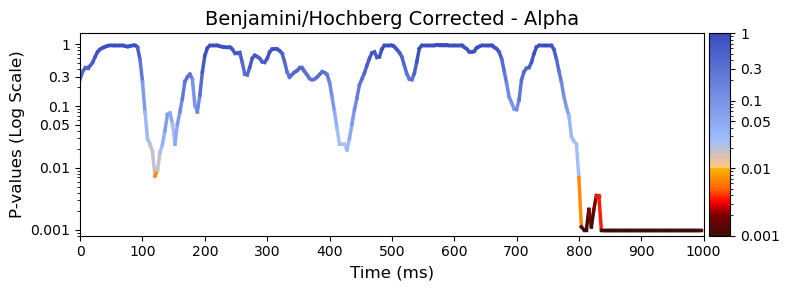

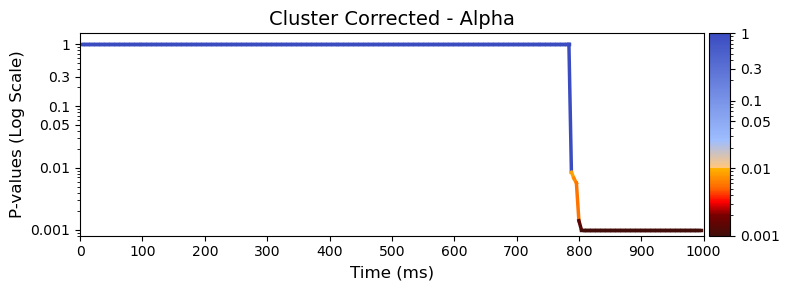

In [13]:
# Set up parameters
xlabel = "Time (ms)"
x_tick_min = 0
x_tick_max = 1000
num_x_ticks = 11
alpha = 0.01

# Plot uncorrected p-values
graphics.plot_p_values_over_time(
    results_multivariate["pval"],
    title_text=f"Uncorrected - {band_name.capitalize()}",
    xlabel=xlabel,
    x_tick_min=x_tick_min,
    x_tick_max=x_tick_max,
    num_x_ticks=num_x_ticks,
    alpha = alpha,
    save_path="3_multi_uncorrected.pdf",
)

# Plot Benjamini/Hochberg corrected p-values
graphics.plot_p_values_over_time(
    pval_fdr_bh,
    title_text=f"Benjamini/Hochberg Corrected - {band_name.capitalize()}",
    xlabel=xlabel,
    x_tick_min=x_tick_min,
    x_tick_max=x_tick_max,
    num_x_ticks=num_x_ticks,
    alpha=alpha,
    save_path="3_multi_fdr_bh.pdf"
)    

# Plot cluster corrected p-values
graphics.plot_p_values_over_time(
    pval_cluster,
    title_text=f"Cluster Corrected - {band_name.capitalize()}",
    xlabel=xlabel,
    x_tick_min=x_tick_min,
    x_tick_max=x_tick_max,
    num_x_ticks=num_x_ticks,
    alpha=alpha,
    save_path="3_multi_cluster.pdf"
)

#### Conclusion - Multivariate

The multivariate analysis found a significant time window between 820–1000 ms in the alpha band (8–13 Hz) when comparing data across sessions. This suggests that brain activity patterns during this late phase of the task consistently differ between sessions.

Alpha band activity is often linked to attention and sensory processing, particularly in visual tasks. The significant result during this time may reflect differences in how the brain maintains attention or processes information related to the task across sessions.

Overall, this finding indicates that brain activity in the alpha band changes consistently during the later stages of the trial, when the brain may be consolidating or finalising its response to the task conditions.

### Step 7. Univariate Test <a id="uni_test"></a>
The univariate test examines the relationship between individual brain states ($D$, represented by ```Gamma_epoch```) and the behavioural condition ($R$, represented by ```R_data_epoch```) across sessions. Unlike the multivariate test, which considers the combined effect of all brain states, the univariate approach analyses each state separately. 

In the context of across-session testing, the univariate test helps identify:  
- **Which brain states** show significant differences in activity across sessions.  
- **When** these differences occur during the task.  

- **Significant results**: suggest that a specific brain state is associated to differences in how animate and inanimate objects are processed across sessions.

---

##### Inputs and Settings

To perform the univariate analysis using the `test_across_sessions_within_subject` function, the following inputs and settings are specified:

**Inputs:**
* ```D_data```: The state time courses of the brain data (```gamma_epoch```).
* ```R_data```: The behavioural measurements representing the stimuli condition (```R_data_epoch```).
* ```idx_data``` : Index of the first and last trial for a given session (```idx_data_epoch```)

**Settings:**
* ```method = "univariate"```: Specifies that the test should perform univariate analysis.
* ```Nperm```: Number of permutations (optional, default is 1000).
---

##### Run the ```test_across_sessions_within_subject``` function
We will store the results in a dictionary called `results_univariate`, which will hold the outputs for the selected frequency band.

Here’s the code to perform the test:  

In [14]:
# Set parameters for univariate testing
method = "univariate"
Nperm = 10_000  # Number of permutations

results_univariate = statistics.test_across_sessions_within_subject(
    gamma_epoch,
    R_data_epoch,
    idx_data_epoch,
    method=method,
    Nperm=Nperm,
)

Maximum number of permutations with 15 sessions is: 1.31e+12
performing permutation testing per timepoint


100%|██████████| 250/250 [1:01:07<00:00, 14.67s/it]


The output structure of `result_univariate` is the same as for the multivariate test and will not be repeated here.

#### Step 8. Multiple Comparison - Univariate <a id="uni_corr"></a>
When running statistical tests, especially multivariate ones, it’s important to account for multiple comparisons. This helps reduce the risk of false positives (type I errors). To handle this, we apply two types of corrections to the p-values from the `results_univariate` output:

* Benjamini/Hochberg Correction: This method adjusts p-values to control for false discovery rates. This uses the `pval_correction` function, which offers various correction methods based on the `statsmodels` multitest module.

* Cluster-Based Correction: This method identifies clusters of significant results in the data to reduce the risk of false positives. Since each brain state is independent, we set `individual_feature=True` to apply the correction separately for each state. We focus on p-values below a threshold of 0.01 by setting `alpha=0.01`. This is implemented using the `pval_cluster_based_correction` function.

Here’s how we apply these corrections:

In [15]:
# Apply Benjamini/Hochberg correction to multivariate p-values
pval_fdr_bh, _ = statistics.pval_correction(
        results_univariate, method='fdr_bh'
    )

# Apply cluster-based correction to multivariate p-values
alpha = 0.01  # Significance threshold

pval_cluster = statistics.pval_cluster_based_correction(
    results_univariate,
    alpha=alpha,
    individual_feature=True
)

#### Step 9. P-value plots - Univariate <a id="uni_corr2"></a>
With both uncorrected and corrected p-values calculated, we can now visualise them using the `plot_p_value_matrix` function.\
This helps better understand the results by showing how p-values change over time for each condition.
For the univariate test, the p-values are stored as an array with the shape `[number of time points, p, q]`, where $p$=12 (representing 12 states), and $q$=1 (indicating a single array that differentiates between animate and inanimate objects).

In our case, the p-value array has the shape (250, 12), as the data spans 250 time points per trial and 12 states.\
Since the stimulus presentation starts at 0 seconds and ends after 1000 ms, we will set the x-axis limits to:
* `x_tick_min = 0`
* `x_tick_max = 1000`

And we will be focusing on p-values below a threshold of 0.01
* `alpha = 0.01`




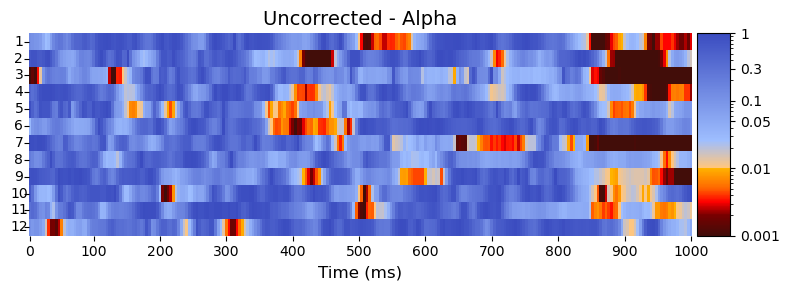

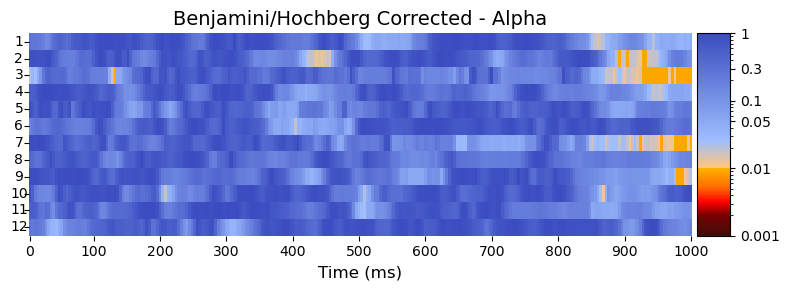

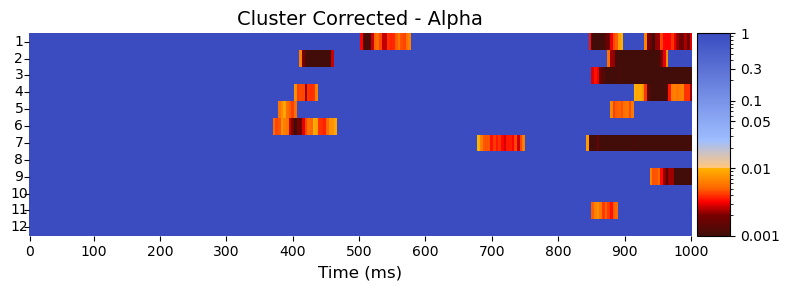

In [16]:
# Set up parameters
figsize = (8, 3)  # Adjust figure size to accommodate multiple subplots
xlabel = "Time (ms)"
x_tick_min = 0
x_tick_max = 1000
num_x_ticks = 11
alpha = 0.01


# Plot uncorrected p-values
graphics.plot_p_value_matrix(
    results_univariate["pval"].T,
    title_text=f"Uncorrected - {band_name.capitalize()}",
    figsize =figsize,
    xlabel=xlabel,
    x_tick_min=x_tick_min,
    x_tick_max=x_tick_max,
    num_x_ticks=num_x_ticks,
    alpha = alpha,
    save_path="3_uni_uncorrected.pdf"
)

# Plot Benjamini/Hochberg corrected p-values
graphics.plot_p_value_matrix(
    pval_fdr_bh.T,
    title_text=f"Benjamini/Hochberg Corrected - {band_name.capitalize()}",
    figsize =figsize,
    xlabel=xlabel,
    x_tick_min=x_tick_min,
    x_tick_max=x_tick_max,
    num_x_ticks=num_x_ticks,
    alpha=alpha,
    save_path="3_uni_fdr_bh.pdf"
) 

# Plot cluster-based corrected p-values
graphics.plot_p_value_matrix(
    pval_cluster.T,
    title_text=f"Cluster Corrected - {band_name.capitalize()}",
    figsize =figsize,
    xlabel=xlabel,
    x_tick_min=x_tick_min,
    x_tick_max=x_tick_max,
    num_x_ticks=num_x_ticks,
    alpha=alpha,
    save_path="3_uni_cluster.pdf"
)

#### Conclusion - Univariate
The univariate analysis across sessions identified significant differences in brain activity, particularly during the later stages of the trials. These findings, obtained after correcting for multiple comparisons, demonstrate how individual brain states contribute to changes in brain activity across sessions.

After Benjamini/Hochberg correction:
* A few significant differences were detected in States 2, 3, 7, and 9 toward the end of the trials. Although there were indications of broader time windows with potential significance, the correction appeared overly conservative, likely over-penalising the p-values.

After cluster correction:
* Consistent significant time windows were observed in States 1, 2, 4, 5, and 6 between 350–500 ms. Additional significant time windows were identified in States 3, 4, 7, 8, and 9 from 820–1000 ms.

These results align with the multivariate test, which also revealed changes in brain activity during the late phase of the trials. However, the univariate analysis provides more detailed insights by pinpointing specific brain states that are involved during earlier periods. Cluster correction proved more effective at detecting these patterns compared to Benjamini/Hochberg correction.

Overall, the differences between sessions appear minimal, with most variations occurring toward the end of the trials.

### Extra - FWER Correction <a id="uni_test3"></a>
We can also perform FWER correction using the MaxT method directly by setting `FWER_correction=True`. However, we can also apply FWER correction using the function`pval_FWER_correction`

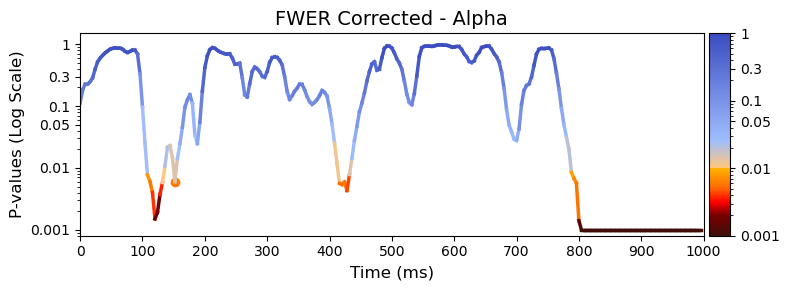

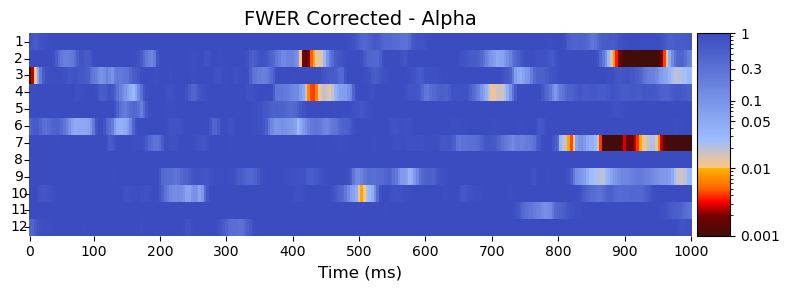

In [17]:
# Run FWER afterwards
pval_multivariate_FWER =statistics.pval_FWER_correction(results_multivariate)

pval_univariate_FWER = statistics.pval_FWER_correction(results_univariate)
# Plot FWER corrected p-values
graphics.plot_p_values_over_time(
    pval_multivariate_FWER,
    title_text=f"FWER Corrected - {band_name.capitalize()}",
    xlabel=xlabel,
    x_tick_min=x_tick_min,
    x_tick_max=x_tick_max,
    num_x_ticks=num_x_ticks,
    alpha = alpha,
    save_path="3_multi_FWER.pdf"
    )

# Plot FWER corrected p-values
graphics.plot_p_value_matrix(
    pval_univariate_FWER.T,
    title_text=f"FWER Corrected - {band_name.capitalize()}",
    figsize =figsize,
    xlabel=xlabel,
    x_tick_min=x_tick_min,
    x_tick_max=x_tick_max,
    num_x_ticks=num_x_ticks,
    alpha = alpha,
    save_path="3_uni_FWER.pdf"
)

**Considerations for different multiple comparisons test**

MaxT correction
* Provides strict control over false positives
* Suitable for high-stakes studies where minimising Type I errors is essential
* Reduces statistical power compared to other methods
    * **Note**: When there is only one variable (e.g., a single stimulus type or feature), MaxT correction functions the same as standard permutation p-values since there are no multiple tests to compare. However, for univariate tests across multiple time points, MaxT correction effectively controls the family-wise error rate by accounting for multiple comparisons across time.

FDR-BH correction
* Balances error control and statistical power, making it appropriate for exploratory studies where detecting true effects is prioritised and a small proportion of false positives is acceptable

Cluster correction
* Effective at removing small clusters of significant values
* Less conservative in preserving large areas of significant differences
* Useful when dealing with multiple comparisons across time or space.